# Time Series Forecasting

Author: Charles Liu

This notebook includes the data preprocessing, model creation, training, testing and visualizations

This forecasting model can be treated in two ways:
  1. Regression: predict the close price of the next day, where the price is numeric.
  2. Classification: predict the future close return to positive or negative

## Part I. Close Price Forecasting

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt


TICKER = 'CBA'
MISSING_VALUE_STRAGETY = 'mean'

## Prepare data

### Select a ticker and read the data to data frame

In [2]:
# Read dataframe. Here only a dates with valid prices of the selected ticker is read
from pricedata import read_stock_data, read_dates
df_raw = read_stock_data(TICKER)

print("Raw data shape:",  df_raw.shape)
df_raw.head()

Raw data shape: (879, 5)


,open,high,low,close,volume
date,,,,,
2015-01-02,85.42,85.74,85.12,85.74,944323
2015-01-05,85.70,86.24,85.51,85.95,1344368
2015-01-06,85.10,85.80,84.87,85.30,2463926
2015-01-07,85.31,85.49,84.55,85.11,2115727
2015-01-08,85.54,85.65,85.13,85.39,1986996


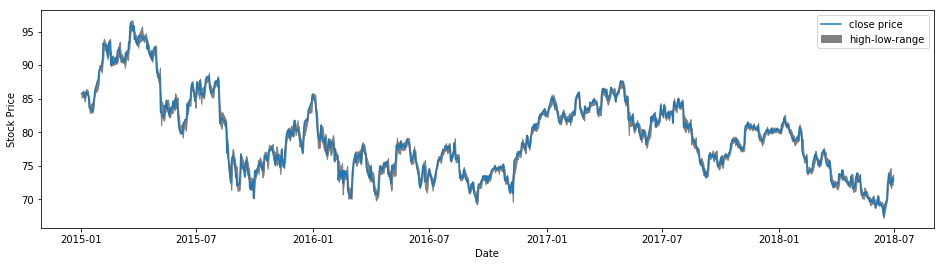

In [3]:
# Visualize the raw data. We see the the variance of the prices on a day is much smaller than the prices across time.
df = df_raw
fig = plt.figure(figsize=(16, 4))
plt.plot(df.index, df['close'], "-", label='close price')
plt.fill_between(df.index, y1=df['low'], y2=df['high'], color='gray', label='high-low-range')
plt.xlabel("Date")
plt.ylabel('Stock Price')
plt.legend()
plt.show()
plt.close()

### Handling missing data.

In the base model, missing data in each column is filled with mean values columns

In [4]:
if MISSING_VALUE_STRAGETY is None:
    df_full = df_raw

In [5]:
if MISSING_VALUE_STRAGETY == 'mean':
    dates = read_dates()
    if len(dates) > len(df_raw):
        df_full = pd.DataFrame(index=dates, columns=df_raw.columns, dtype=float)
        df_full.loc[df_raw.index] = df_raw.astype(float)


    # Discard the dates before the first valid data
    df_full = df_full.loc[df_raw.index[0]:]

    print("Raw data shape:",  df_full.shape)

    df_full.head()

Raw data shape: (883, 5)


In [6]:
if MISSING_VALUE_STRAGETY == 'mean':
    # Read full trading dates and create a dataframe with full trading dates. 
    from sklearn.preprocessing import Imputer
    imputer = Imputer(missing_values='NaN', strategy='mean', axis=0)
    imputer.fit(df_raw.values)

    X = imputer.transform(df_full.values)
    df_full = pd.DataFrame(X, index=df_full.index, columns=df_full.columns)
    df_full.head()

/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [7]:
if MISSING_VALUE_STRAGETY == 'interpolate':
    # Read full trading dates and create a dataframe with full trading dates. 
    dates = read_dates()
    if len(dates) > len(df_raw):
        df_full = pd.DataFrame(index=dates, columns=df_raw.columns, dtype=float)
        df_full.loc[df_raw.index] = df_raw.astype(float)

    # Discard the dates before the first valid data
    df_full = df_full.loc[df_raw.index[0]:]
    df_full.shape

    # Fill the NaN with time interpolation
    if df_full.isna().sum().sum() > 0:
        df_full = df_full.interpolate(method='linear')
    df_full.head()

2. Scaling

For stock prices and trading volumes, the Min-Max scaler is an appropriate scaler. In contrast, the standard scaler will produce negative values which make no sense in this occasion.

In [8]:
from sklearn.preprocessing import MinMaxScaler as Scaler
scaler = Scaler(feature_range = (0, 1))
X = scaler.fit_transform(df_full.values)
df_scaled = pd.DataFrame(index=df_full.index, data=X, columns=df_full.columns)
df_scaled.head()

,open,high,low,close,volume
2015-01-02,0.619147,0.619395,0.634752,0.633530,0.019451
2015-01-05,0.628931,0.636774,0.648582,0.640804,0.049284
2015-01-06,0.607966,0.621481,0.625887,0.618289,0.132774
2015-01-07,0.615304,0.610706,0.614539,0.611708,0.106807
2015-01-08,0.623340,0.616267,0.635106,0.621406,0.097207


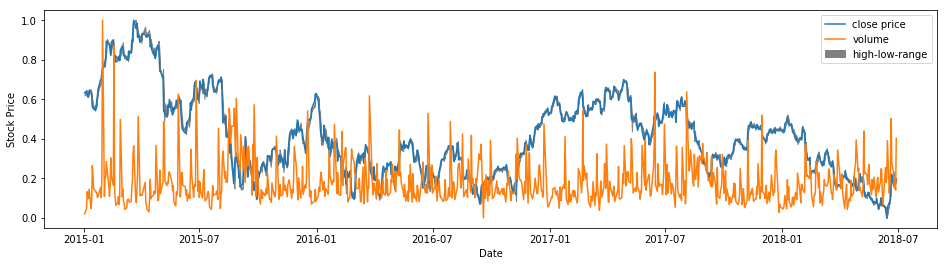

In [9]:
# Visualize the scaled data. 
df = df_scaled
fig = plt.figure(figsize=(16, 4))
plt.plot(df.index, df['close'], "-", label='close price')
plt.fill_between(df.index, y1=df['low'], y2=df['high'], color='gray', label='high-low-range')
plt.plot(df.index, df['volume'], label='volume')
plt.xlabel("Date")
plt.ylabel('Stock Price')
plt.legend()
plt.show()
plt.close()

### Prepare the training, validation and test data
Here are about my feature selection.
   1. Input features: The Open, high, low and high prices and the trading volume are used.
   2. Look back time: 5 days, i.e. totally 25 features will be used.
   3. Target feature: the close price of the next day

In [10]:
lookback = 5
features = 5
delay = 1

total_samples = len(df_full) - lookback - delay + 1
training_samples = int(total_samples * 0.6)
validation_samples = int(total_samples * 0.2)
test_samples = total_samples - training_samples - validation_samples

print("Total samples:", total_samples)
print("Training:", training_samples)
print("Validation:", validation_samples)
print("Test:", test_samples)

Total samples: 878
Training: 526
Validation: 175
Test: 177


In [60]:
from helpers import sample_generator, vectorize_input, vectorize_target

sample_generator = sample_generator(df_scaled, lookback=lookback, delay=delay, target_col=3)
sample_data = list(sample_generator)

np.random.shuffle(sample_data)

X_data = vectorize_input(sample_data)
y_data = vectorize_target(sample_data)

X_train = X_data[:training_samples]
y_train = y_data[:training_samples]

X_valid = X_data[training_samples: training_samples + validation_samples]
y_valid = y_data[training_samples: training_samples + validation_samples]

X_test = X_data[training_samples + validation_samples: ]
y_test = y_data[training_samples + validation_samples: ]


X_train = X_train.reshape(X_train.shape[0], 1, lookback * features)
X_valid = X_valid.reshape(X_valid.shape[0], 1, lookback * features)
X_test = X_test.reshape(X_test.shape[0], 1, lookback * features)

X_train.shape

(526, 1, 25)

### A forecasting model using recurrent neural networks

In [18]:
from keras.models import Sequential
from keras import layers

def build_model(units):
    units = 32

    model = Sequential()

    model.add(layers.LSTM(units=units, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(layers.Dropout(rate=0.2))

    model.add(layers.LSTM(units=units, return_sequences=True))
    model.add(layers.Dropout(rate=0.2))

    model.add(layers.LSTM(units=units, return_sequences=True))
    model.add(layers.Dropout(rate=0.2))

    model.add(layers.LSTM(units=units))
    model.add(layers.Dropout(rate=0.2))

    model.add(layers.Dense(units=units, activation='relu'))

    model.add(layers.Dense(units=1))
    
    return model

model = build_model(units = 32)
model.compile(optimizer='adam', loss='mean_absolute_error')
history = model.fit(X_train, y_train, epochs=100, batch_size=lookback* features, validation_data=(X_valid, y_valid))

Train on 526 samples, validate on 175 samples
Epoch 1/100
526/526 [==============================] - 5s 10ms/step - loss: 0.3556 - val_loss: 0.2954
Epoch 2/100
526/526 [==============================] - 0s 604us/step - loss: 0.1959 - val_loss: 0.1123
Epoch 3/100
526/526 [==============================] - 0s 605us/step - loss: 0.1168 - val_loss: 0.0949
Epoch 4/100
526/526 [==============================] - 0s 597us/step - loss: 0.0900 - val_loss: 0.0716
Epoch 5/100
526/526 [==============================] - 0s 596us/step - loss: 0.0718 - val_loss: 0.0468
Epoch 6/100
526/526 [==============================] - 1s 960us/step - loss: 0.0690 - val_loss: 0.0413
Epoch 7/100
526/526 [==============================] - 0s 595us/step - loss: 0.0678 - val_loss: 0.0416
Epoch 8/100
526/526 [==============================] - 0s 607us/step - loss: 0.0656 - val_loss: 0.0408
Epoch 9/100
526/526 [==============================] - 0s 592us/step - loss: 0.0637 - val_loss: 0.0516
Epoch 10/100
526/526 [======

526/526 [==============================] - 0s 713us/step - loss: 0.0374 - val_loss: 0.0322
Epoch 80/100
526/526 [==============================] - 0s 745us/step - loss: 0.0362 - val_loss: 0.0330
Epoch 81/100
526/526 [==============================] - 0s 771us/step - loss: 0.0395 - val_loss: 0.0297
Epoch 82/100
526/526 [==============================] - 1s 1ms/step - loss: 0.0356 - val_loss: 0.0297
Epoch 83/100
526/526 [==============================] - 0s 719us/step - loss: 0.0366 - val_loss: 0.0313
Epoch 84/100
526/526 [==============================] - 0s 715us/step - loss: 0.0340 - val_loss: 0.0312
Epoch 85/100
526/526 [==============================] - 0s 720us/step - loss: 0.0403 - val_loss: 0.0333
Epoch 86/100
526/526 [==============================] - 0s 682us/step - loss: 0.0384 - val_loss: 0.0327
Epoch 87/100
526/526 [==============================] - 1s 1ms/step - loss: 0.0380 - val_loss: 0.0312
Epoch 88/100
526/526 [==============================] - 0s 695us/step - loss: 0.0

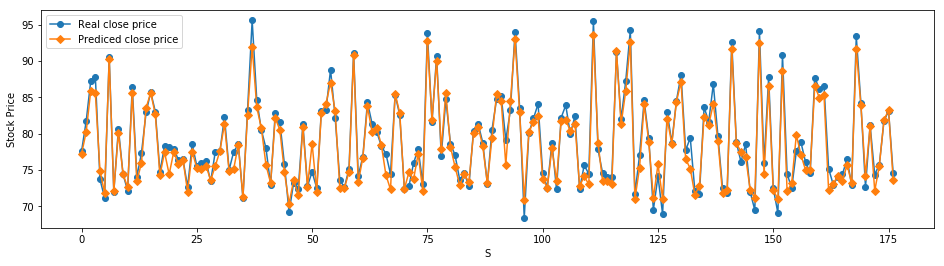

In [13]:
# Predict the model
y_test_real = y_test
y_test_pred = model.predict(X_test).reshape(-1,)

# Inverse the scale
y_test_real = scaler.inverse_transform(np.array([y_test_real] * 5).transpose())[:,0]
y_test_pred = scaler.inverse_transform(np.array([y_test_pred] * 5).transpose())[:,0]


# Visualize the raw data. We see the the variance of the prices on a day is much smaller than the prices across time.
fig = plt.figure(figsize=(16, 4))
plt.plot(y_test_real, "o-", label='Real close price')
plt.plot(y_test_pred, "D-", label='Prediced close price')
plt.xlabel("S")
plt.ylabel('Stock Price')
plt.legend()
plt.show()
plt.close()

## Part II: Future close return classification

In [50]:
from keras.utils import to_categorical

def future_close_return(X, y):
    fcr =  y / X[:, 0, -2] - 1
    return fcr
    
    
train_labels = future_close_return(X_train, y_train) > 0
valid_labels = future_close_return(X_valid, y_valid) > 0
test_labels = future_close_return(X_test, y_test) > 0

# classifier = build_model(32)
# #classifier.compile(optimizer='adam', loss='mean_absolute_error')
# classifier.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
# classification_history = classifier.fit(X_train, train_labels, epochs=100, batch_size=lookback * features,
#                                         validation_data=(X_valid, valid_labels))

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in double_scalars
  after removing the cwd from sys.path.


In [55]:
future_close_return(X_train, y_train)[:10]

array([-0.06133828996282509, -0.08110065170166603, -0.21746293245469484,
       0.004366812227074801, 0.03109919571045605, -0.03148425787106446,
       -0.01047443006777582, 0.033183856502242204, -0.05416116248348635,
       0.003007518796992459], dtype=object)

In [54]:
df = df_scaled
df.close / df.close.shift(1) - 1

2015-01-02         NaN
2015-01-05    0.011482
2015-01-06   -0.035135
2015-01-07   -0.010644
2015-01-08    0.015855
2015-01-09    0.036232
2015-01-12   -0.020979
2015-01-13   -0.019231
2015-01-14   -0.090756
2015-01-15   -0.010474
2015-01-16    0.003736
2015-01-19   -0.029156
2015-01-20    0.025559
2015-01-21    0.072897
2015-01-22    0.032520
2015-01-23    0.056243
2015-01-27    0.074547
2015-01-28    0.003469
2015-01-29    0.052346
2015-01-30    0.026748
2015-02-02    0.015996
2015-02-03    0.032389
2015-02-04    0.016993
2015-02-05    0.106255
2015-02-06   -0.011232
2015-02-09   -0.001958
2015-02-10   -0.013344
2015-02-11   -0.029037
2015-02-12   -0.027857
2015-02-13    0.083017
                ...   
2018-05-18   -0.177898
2018-05-21   -0.134426
2018-05-22    0.060606
2018-05-23   -0.157143
2018-05-24   -0.093220
2018-05-25    0.130841
2018-05-28   -0.107438
2018-05-29    0.342593
2018-05-30   -0.258621
2018-05-31   -0.139535
2018-06-01   -0.324324
2018-06-04    0.792000
2018-06-05 